Analysis.ipynb  - Interesting ways to explore the data

socialsent/ - Actual code for the package

data/:

    Outputs and Inputs (make sep folder within for outputs and inputs):

    - Make a file in folder called outputs.json 
    - Have the following file structure:
        {'body': 'your text'},
        {'body': 'your text 2'},
         

SocialSentRunning.ipynb - this script

DEFAULT SEEDS:

In [1]:
from socialsent import seeds
print(seeds.POSITIVE_TWEET)
print(seeds.NEGATIVE_TWEET)

['love', 'loved', 'loves', 'awesome', 'nice', 'amazing', 'best', 'fantastic', 'correct', 'happy']
['hate', 'hated', 'hates', 'terrible', 'nasty', 'awful', 'worst', 'horrible', 'wrong', 'sad']


# Required functions

SOCIALSENT Function

In [2]:
from socialsent.reddit import subreddit_run, subredditgen
from socialsent import constants
from argparse import ArgumentParser


def compute_polarities(subreddit,  stem=False,  positive_seeds = [], negative_seeds = [],
                       window_size=None,low_thresh=100,run=True,gen=True):
    '''
    
    subreddit - string - name of folder in /data file with outputs.json
    stem - BOOL - whether to stem or not
    positive_seeds - list - list of positive seeds
    negative_seeds - list - list of negative seeds
    window_size - int - if None, treat entire row as one
    low_thresh - int - exclude words below this threshold
    
    '''
    
    interval=None
    intervals=None

    if positive_seeds:
        seeds.POSITIVE_TWEET = positive_seeds
        seeds.NEGATIVE_TWEET = negative_seeds


    constants.set_constants(stem, interval, intervals,gender=False,low_thresh=low_thresh)
    if gen == True:
        subredditgen.main(subreddit,window_size)
    
    if run == True:
        subreddit_run.main(subreddit)

In [3]:
pos_seeds = seeds.POSITIVE_TWEET
neg_seeds = seeds.NEGATIVE_TWEET

UTILITY methods

In [4]:
def load_df(sub, prefix='', scale=True, counts=True):
    pols = pickle.load(
        open("data/{}/{}polarities.pkl".format(sub, prefix), "rb"))
    means = defaultdict(list)
    for run in pols:
        for word, value in run.items():
            means[word].append(value)

    df = pd.DataFrame([(word, np.nanmean(values), np.nanstd(values))
                       for word, values in means.items()],
                      columns=["word", "mean_sent", "std"])

    df = df.sort_values(by=["mean_sent"], ascending=False)

    if counts:
        get_top5_coocs(df, sub, prefix)

    if scale:
        scaler = StandardScaler(with_std=False)
        df["mean_sent"] = scaler.fit_transform(df["mean_sent"].values.reshape(
            -1, 1))
    df = df[df["word"].apply(lambda x: len(x)) > 1]

    return df.set_index('word')


def get_top5_coocs(df, subreddit, prefix):
    mat = sparse_io.retrieve_mat_as_coo("data/{}/{}counts.bin".format(
        subreddit, prefix).encode()).tocsr()
    index = pickle.load(
        open('data/{}/{}index.pkl'.format(subreddit, prefix), 'rb'))

    arr = np.array(mat.todense())

    rev_index = {v: k for k, v in index.items()}

    # remove words that we don't need counts for
    pol_idx = np.array([index[word] for word in df['word']])
    arr = arr[pol_idx, :]

    # remove stopwords
    stopword_idx = np.array(
        [index[stopword] for stopword in STOPWORDS if stopword in index])
    arr[:, stopword_idx] = 0

    top_idx = np.argsort(arr, axis=1)[:, -5:]

    top_words = [list(map(lambda x: rev_index[x], row)) for row in top_idx]
    df['cooccurring_words'] = top_words

In [5]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from collections import defaultdict
from gensim.parsing.preprocessing import STOPWORDS
from sklearn.preprocessing import StandardScaler

import json
from tqdm.notebook import tqdm

import os

# Wiki Example 

In [6]:
from vaderSentiment import vaderSentiment

In [7]:
sentiment = vaderSentiment.SentimentIntensityAnalyzer()

sortedSenti = sorted(sentiment.lexicon.items(), key=lambda x:x[1])
sentiment.lexicon['kill']
sortedSenti[:25]

[('rapist', -3.9),
 ('raping', -3.8),
 ('slavery', -3.8),
 ('fu', -3.7),
 ('kill', -3.7),
 ('murder', -3.7),
 ('rape', -3.7),
 ('terrorist', -3.7),
 ('hatefulness', -3.6),
 ('hell', -3.6),
 ('motherfucker', -3.6),
 ('murderer', -3.6),
 ('raped', -3.6),
 ('rapers', -3.6),
 ('terrorism', -3.6),
 ('fatality', -3.5),
 ('killed', -3.5),
 ('killings', -3.5),
 ('rapes', -3.5),
 ('suicidal', -3.5),
 ('suicide', -3.5),
 ('torturers', -3.5),
 ('apocalyptic', -3.4),
 ('brutalizing', -3.4),
 ('cancer', -3.4)]

In [8]:
["freedom", "glorious", "glory", "perfect", "perfectly", "paradise", "reign", "help", "recovered", "recover", "helped", "free", "freed", "liberate", "liberated", "save", "saved", "intervened", "support", "resolve", "resolved", "geurrilla", "leader", "safe", "safety"]
["enslaved", "murder", "murdered", "terror", "terrorist", "terrorism", "murderer", "brutal", "brutalizing", "dictator", "massacre", "oppressed", "loot", "looted", "pillage", "pillaged", "regime", "genocide", "horror", "horrors", "oppressor", "oppressors", "occupy", "occupation", "cruel"]
 

['enslaved',
 'murder',
 'murdered',
 'terror',
 'terrorist',
 'terrorism',
 'murderer',
 'brutal',
 'brutalizing',
 'dictator',
 'massacre',
 'oppressed',
 'loot',
 'looted',
 'pillage',
 'pillaged',
 'regime',
 'genocide',
 'horror',
 'horrors',
 'oppressor',
 'oppressors',
 'occupy',
 'occupation',
 'cruel']

Use vader sentiment list of words

look at which words occur frequently in corpus

manually select these seed words

input into socialsent

In [9]:
data = 'WikipediaTest'

In [10]:
pos_seeds = seeds.POSITIVE_HIST
neg_seeds = seeds.NEGATIVE_HIST

compute_polarities(data,positive_seeds=pos_seeds,negative_seeds=neg_seeds,window_size=100,low_thresh=20)

Getting and writing dictionary...


100%|███████████████████████████████████████████████████████████████████████| 215317/215317 [00:15<00:00, 14245.75it/s]


Generating word co-occurrences...


100%|████████████████████████████████████████████████████████████████████████| 215317/215317 [1:00:55<00:00, 58.90it/s]


Generating PPMI vectors...
Generating SVD vectors...
Factorising 52381998 with shape (13010, 13010)
Create representation...
Get sub embedding...
Bootstrapping...
using seeds ['love', 'helped', 'safe', 'safety', 'happy', 'help', 'geurrilla', 'good', 'loved', 'reign', 'support', 'resolve', 'liberate', 'recover', 'perfectly', 'save', 'glorious', 'fortunate', 'saved', 'freed', 'delightful', 'glory', 'paradise', 'liberated', 'excellent', 'recovered', 'free', 'pleasant', 'lovely', 'leader', 'freedom', 'perfect', 'resolved', 'intervened'] ['bad', 'evil', 'hated', 'occupy', 'pillaged', 'dictator', 'oppressors', 'occupation', 'murderer', 'unfortunate', 'loot', 'poor', 'murdered', 'pillage', 'cruel', 'terror', 'regime', 'murder', 'horror', 'brutal', 'unpleasant', 'oppressed', 'looted', 'horrors', 'genocide', 'hate', 'disgusting', 'terrorism', 'horrible', 'brutalizing', 'oppressor', 'terrorist', 'enslaved', 'massacre', 'unhappy']


100%|█████████████████████████████████████████████████| 50/50 [27:05<00:00, 32.50s/it]


In [11]:
df = load_df(data,counts=False)

In [12]:
df.head(50)

,mean_sent,std
word,,
provide,0.516804,0.048147
role,0.514322,0.061087
supporting,0.506619,0.056769
received,0.500658,0.134397
danger,0.493707,0.042939
wanted,0.482886,0.134157
bring,0.481069,0.070142
keep,0.473260,0.138215
gave,0.472454,0.154185


<AxesSubplot: >

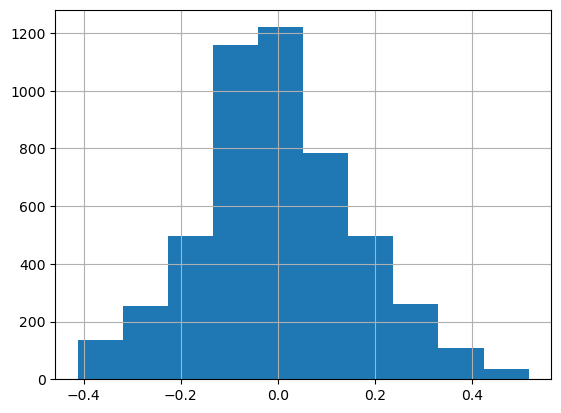

In [13]:
df.mean_sent.hist()

In [14]:
df.tail(200)

,mean_sent,std
word,,
allied,-0.287583,0.144915
town,-0.287925,0.074631
reports,-0.288307,0.066134
violence,-0.288485,0.059153
execution,-0.289183,0.077333
...,...,...
atrocities,-0.406785,0.028744
raped,-0.408845,0.026111
cases,-0.408889,0.030532


In [15]:
with open(f'data/{data}/polarities.pkl','rb') as file:
    pols = pickle.load(file)

In [16]:
pols

[{'competing': 0.5207395944744903,
  'similar': 0.5283171716278062,
  'otherwise': 0.6679140132165843,
  'kept': 0.9009549041437398,
  'envoy': 0.6789265805858818,
  'ruins': 0.7668427279803157,
  'supreme': 0.42846073497980036,
  'los': 0.37854143013523023,
  'targets': 0.10342264952920546,
  'yusuf': 0.22705710664273335,
  'autonomous': 0.3215378420401343,
  'dominance': 0.7771719685268299,
  'emir': 0.2893556772315329,
  'letters': 0.1726060760730307,
  'colombian': 0.24641705278996923,
  'radical': 0.5534000459235392,
  'lords': 0.4669593670226654,
  'mixed': 0.40850937813169813,
  'deeply': 0.4640922210750421,
  'shooting': 0.15191293212068657,
  'ultimately': 0.6197185597501088,
  'enemies': 0.5909785900970882,
  'kurds': 0.17020372075567033,
  'w': 0.06497996151278246,
  'wilson': 0.32631628446110006,
  'iraq': 0.21700727189738625,
  'taizong': 0.5009862804698272,
  'faction': 0.8605597475572444,
  'lines': 0.3639776895520567,
  'simple': 0.8256933603310411,
  'interpretation': 

In [17]:
pd.options.display.max_rows = 4947

In [18]:
df.loc['took']

mean_sent    0.135589
std          0.122532
Name: took, dtype: float64

In [19]:
dd = df.mean_sent.to_dict()

In [20]:
for k in list(dd.keys()):
    if abs(dd[k])<0.2:
        del dd[k]

AttributeError: 'dict' object has no attribute 'hist'

In [23]:
with open('data/WikipediaTest/labelled-outputs.json', 'r') as file:
    sentenceDict = json.load(file)

In [24]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\super\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [114]:


tempKey = ""
totalSenti = 0
sentiDict = {}
counter = 0
articleWords = 0
for a, b in sentenceDict.items():
    #print("\nthis is sentence " + str(counter))
    if tempKey == "":
        #print("\nSTART")
        index = a.find('_')
        tempKey = a[:index]
        #print("\nfirst working article title is:" + tempKey)
    article = a[:a.find('_')]
    #print("\nthis article is: " + article)
    wordList = nltk.word_tokenize(b.lower())
    sentenceSenti = 0
    sentenceWords=0
    for word in wordList:
        try: 
            wordSent = abs(dd[word])
            #print("\nthe word " + word + " has sentiment score: " + str(wordSent))
            sentenceSenti += wordSent
            sentenceWords+=1
            articleWords+=1
        except:
            #print("\nthe word " + word + " has has no sentiment score")
            continue
    #print("\nthe number of words in that sentence was: " + str(sentenceWords))
    if article == tempKey:
        #print("\nthis sentence has score: " + str(sentenceSenti))
        totalSenti += sentenceSenti
    else:
        #print("\nthis sentence is for the next article")
        #print("\nthe number of words in that article was: " + str(articleWords-sentenceWords))
        #print("\nthis article has sentiment score " + str(totalSenti))
        sentiDict[tempKey] = totalSenti/(articleWords-sentenceWords)
        articleWords=sentenceWords
        totalSenti = sentenceSenti
        tempKey = article
    sentenceWords=0
    counter+=1
#print("\nthis is the last article")
#print("\nthe number of words in that article was: " + str(articleWords))
#print("\nthis article has sentiment score " + str(totalSenti))
sentiDict[tempKey] = totalSenti/(articleWords)

In [115]:
sentiDict

{'Narmer': 0.2894781438876451,
 'Hor-Aha': 0.2715212806499187,
 'Enmerkar': 0.283070427312036,
 'Kish (Sumer)': 0.2797952933970022,
 'Gilgamesh and Aga': 0.30182028959543356,
 'Sneferu': 0.2681226640467053,
 'Entemena': 0.28559981763142844,
 'Akkadian Empire': 0.28284661264646715,
 'Sargon of Akkad': 0.29010394626707675,
 'Naram-Sin of Akkad': 0.2873561630368705,
 'Gutian people': 0.2994347159485294,
 'Gutian rule in Mesopotamia': 0.28330206080959397,
 'Third Dynasty of Ur': 0.2870449245755945,
 'Eshnunna': 0.2821100043448053,
 'Hammurabi': 0.3004802813278782,
 'Babylonia': 0.28912948215856704,
 'Kassites': 0.28099180162626614,
 'Assyria': 0.2848475514061115,
 'First Sealand dynasty': 0.27963376332693624,
 'Hyksos': 0.2772896847800636,
 'Ahmose I': 0.28549740268686263,
 'Thutmose I': 0.28050924922372467,
 'Thutmose II': 0.27495929019080345,
 'Thutmose III': 0.28397733123924446,
 'Battle of the Ten Kings': 0.2752689646954501,
 'Mycenaean Greece': 0.2872839702720288,
 'Ramesses II': 0.27

In [116]:
unordered = pd.DataFrame.from_dict(sentiDict, orient='index', columns=['average_sentiment'])

In [117]:
final = unordered.sort_values(by=['average_sentiment'])

In [118]:
final

,average_sentiment
Battle of Hunayn,0.230362
Dominican Civil War (1911–1912),0.238372
2000–2006 Shebaa Farms conflict,0.256662
Battle of Suriname,0.261654
Druze power struggle (1658–1667),0.265313
Hungarian invasions of Europe,0.266058
Battle of Torvioll,0.266423
Ottoman–Portuguese conflicts (1586–1589),0.266701
Battle of Ain Dara,0.267771
Sneferu,0.268123


array([[<AxesSubplot: title={'center': 'average_sentiment'}>]],
      dtype=object)

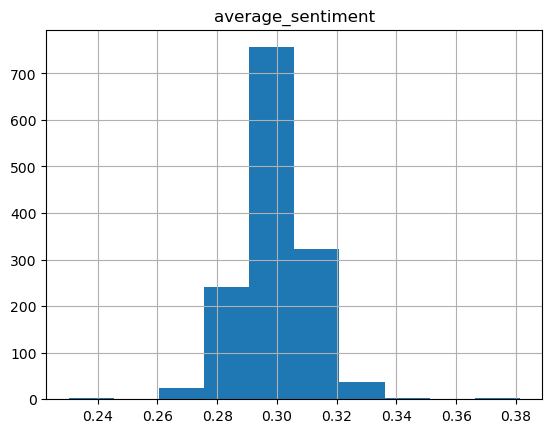

In [119]:
final.hist()

In [5]:
len(final)

NameError: name 'final' is not defined